# Reconstruction de la marée à partir de constantes harmoniques: 

## 1. Rappels sur la marée

![title](figures_ipynb/figures_refmar/constantes_harmoniques.png)

![title](figures_ipynb/figures_refmar/list_constituents.png)

![title](figures_ipynb/figures_refmar/types_de_maree.png)

![title](figures_ipynb/figures_refmar/types_de_maree_dans_le_monde.png)

## 2. Composantes de marée FES 2014: 

**FES**: modèle hydrodynamique qui assimile données in situ (ex: marégraphe) et données d'altimétrie satellitaire, qui a permis la production de données de constantes harmoniques sur une **grile globale au 1/16° en libre accès**.

Dossier des données de composantes de marée

Affichage de l'amplitude et de la phase pour une composante: **M2**

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from os.path import join as join
import numpy as np

# get M2 FES_2014 data
path_fes_2014_data = '/home/florent/ownCloud/R&D/DATA/TIDE/FES_2014/FES2014_b_elevations_extrapolated/ocean_tide_extrapolated/'
constituent = 'm2'
file_constituent = join(path_fes_2014_data, constituent + '.nc')
m2 = Dataset(file_constituent)

# affichage

![title](figures_ipynb/amplitude_in_m2.png)
![title](figures_ipynb/phase_in_m2.png)

## 3. Calcul de la marée à partir des composantes FES 2014: 

In [2]:
def compute_dates(start_date, end_date, step):
    vec_dates = [start_date]
    date_i = start_date
    while date_i < end_date:
        date_i += np.timedelta64(step, 'm')
        vec_dates.append(date_i)
    return vec_dates

def get_closest_grid_point(lons, lats, lon, lat):
    grid_lon, grid_lat = np.meshgrid(lons, lats)
    diffs_lon = np.abs(lons - lon)
    diffs_lat = np.abs(lats - lat)
    ind_lon = np.where(diffs_lon == np.min(diffs_lon))[0][0]
    ind_lat = np.where(diffs_lat == np.min(diffs_lat))[0][0]
    lon_extract = grid_lon[ind_lat, ind_lon]
    lat_extract = grid_lat[ind_lat, ind_lon]
    return ind_lon, ind_lat, lon_extract, lat_extract

def get_fes_wl_at_extraction_point(lons, lats, lon_extraction, lat_extraction, geo_tide):
    ind_lon, ind_lat, lon_extract, lat_extract = get_closest_grid_point(lons, lats, lon_extraction,
                                                                        lat_extraction)
    tide_extract = geo_tide[ind_lat, ind_lon]
    return tide_extract, lon_extract, lat_extract



grid_lons, grid_lats: [[6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]
 [6.95  6.975 7.    7.025 7.05  7.075 7.1   7.125]] 
 [[43.45  43.45  43.45  43.45  43.45  43.45  43.45  43.45 ]
 [43.475 43.475 43.475 43.475 43.475 43.475 43.475 43.475]
 [43.5   43.5   43.5   43.5   43.5   43.5   43.5   43.5  ]
 [43.525 43.525 43.525 43.525 43.525 43.525 43.525 43.525]
 [43.55  43.55  43.55  43.55  43.55  43.55  43.55  43.55 ]
 [43.575 43.575 43.575 43.575 43.575 43.575 43.575 43.575]
 [43.6   43.6   43.6   43.6   43.6   43.6   43.6   43.6  ]
 [43.625 43.625 43.625 43.625 43.625 43.625 43.625 43.625]]


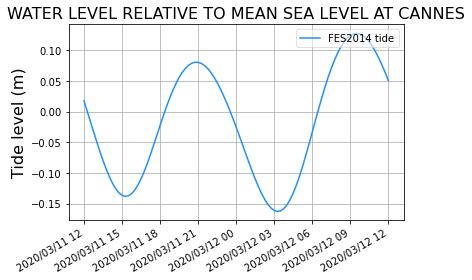

In [14]:
import pyfes
import matplotlib.dates as mdates
import os

# define FES_DATA environment variable
os.environ['FES_DATA'] = path_fes_2014_data

# study location and grid definition
location = 'Cannes'
lon_study = 7.027011
lat_study = 43.545697
grid_step = 0.025
lons = np.arange(np.floor(lon_study * 10) / 10 - 2*grid_step, np.ceil(lon_study * 10) / 10 + 2*grid_step, grid_step)
lats = np.arange(np.floor(lat_study * 10) / 10 - 2*grid_step, np.ceil(lat_study * 10) / 10 + 2*grid_step, grid_step)
grid_lons, grid_lats = np.meshgrid(lons, lats)
print('grid_lons, grid_lats: %s \n %s' %(grid_lons, grid_lats))
shape = grid_lons.shape

# period
start_date = np.datetime64('2020-03-11 12:00')
end_date = np.datetime64('2020-03-12 12:00')
step = 15 # expressed in minutes
vec_dates = compute_dates(start_date, end_date, step)
dates = np.empty(shape, dtype='datetime64[us]')

# Create handler
short_tide = pyfes.Handler("ocean", "memory", 'fes.ini')


# Calculate tide
tide_results = {}
tide_results['tide_from_fes'] = []
tide_results['dates'] = vec_dates

for date in vec_dates:
    dates.fill(date)
    tide, lp, _ = short_tide.calculate(grid_lons.ravel(), grid_lats.ravel(), dates.ravel())
    tide, lp = tide.reshape(shape), lp.reshape(shape)

    # Convert tide to cm and to a 2d numpy masked array
    geo_tide = (tide + lp) * 0.01
    geo_tide = geo_tide.reshape(grid_lons.shape)
    geo_tide = np.ma.masked_where(np.isnan(geo_tide), geo_tide)

    # Extract tide at study location
    tide_extract, lon_extract, lat_extract = get_fes_wl_at_extraction_point(lons, lats, lon_study, lat_study, geo_tide)

    # save tide results in dictionnary
    tide_results['tide_from_fes'].append(tide_extract)


# plot tide at study location
f, ax = plt.subplots()
ax.plot(tide_results['dates'], tide_results['tide_from_fes'], color='dodgerblue', markersize=2, 
        label='FES2014 tide')
ax.set_ylabel('Tide level (m)', fontsize=16)
ax.set_title('WATER LEVEL RELATIVE TO MEAN SEA LEVEL AT {loc}'.format(loc=location.upper()), fontsize=16)
ax.legend(loc='upper right', fontsize=10, framealpha=0.6)
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H'))
f.autofmt_xdate()
plt.show()
